In [1]:
!pip install keras==1.2.2 tensorflow==1.13.1

     |████████████████████████████████| 184kB 7.9MB/s 
     |████████████████████████████████| 92.6MB 43kB/s 
     |████████████████████████████████| 2.8MB 33.0MB/s 
     |████████████████████████████████| 368kB 31.3MB/s 
     |████████████████████████████████| 3.2MB 31.3MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for keras: filename=Keras-1.2.2-cp37-none-any.whl size=209602 sha256=0111fbf85c26fceab8c3f4b265615b095e4a081e4902fcfe9ec139b321fc5376
  Stored in directory: /root/.cache/pip/wheels/55/07/cf/b32db0a8d243b2fd6759d5d7cb650aa20670b2b740209cbf7e
  Created wheel for theano: filename=Theano-1.0.5-cp37-none-any.whl size=2668111 sha256=a83b9bb43ad1a4edc90c52b7079195ba2b681b233741554d596dd8faa5134785
  Stored in directory: /root/.cache/pip/wheels/89/40/74/3a0b7d937890c66c4373120117ebf4ba99f4889b4a0a6a810c
Successfully built keras theano
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.13.1 which is incompatible.
  Found 

In [2]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9MB 7.6MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [13]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [4]:
model = load_model('/content/model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
model.load_weights('/content/model_weight.h5')

In [6]:
encoding_test = pickle.load(open('/content/encoded_images_test.p', 'rb'))
unique = pickle.load(open("/content/unique_captions.p", "rb"))

In [8]:
word2idx = {val:index for index, val in enumerate(unique)}
idx2word = {index:val for index, val in enumerate(unique)}

word2idx['<start>'], idx2word[4776]

(4776, '<start>')

In [9]:
max_len = 40
vocab_size = 8256

In [23]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[1000:]]
            preds = model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

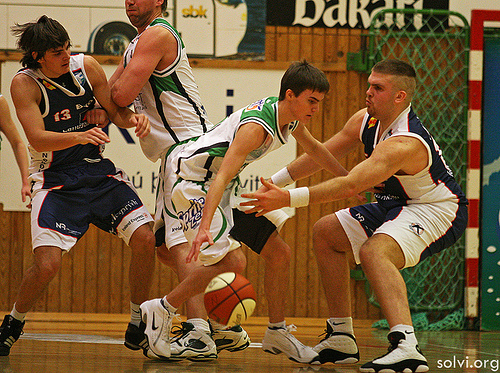

In [11]:
image = Image.open('/content/basketball.png')
image

In [24]:
im_path = '/content/basketball.png'
print(beam_search_predictions(im_path, beam_index=5))

KeyError: ignored